In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of skaro, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import HuberRegressor

from skaro.model import Model
from skaro.utilities.dataframe import aggregated_dataframe, rename_labels
from skaro.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 8192
sim_id = "37_11"

host_star_mass = 1

In [5]:
model = Model(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
    ngpps_star_masses=host_star_mass,
)
ds = model.ds
mw = model.halo

yt : [INFO     ] 2023-11-10 15:30:35,704 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-11-10 15:30:35,875 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-11-10 15:30:35,876 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-10 15:30:35,877 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-10 15:30:35,878 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-11-10 15:30:35,879 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-10 15:30:35,880 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-11-10 15:30:35,881 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-11-10 15:30:35,882 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2023-11-10 15:30:35,883 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-11-10 15:30:35,884 Parameters: hubble_constant      

## PLOT SETUP

In [6]:
set_plot_defaults()

figure_subdirectory = f"MilkyWayAnalogue/{model.resolution}/{model.sim_id}/{model.snapshot}/Galaxy_properties"

## CREATE DATA SOURCE

In [7]:
radius = 0.2 * mw.virial_radius()
sphere_data = mw.sphere(radius=radius)

## GENERAL PROPERTIES

In [8]:
print(
    "Total Stellar Mass : {:.2f} * 10^10 Msun".format(
        np.sum(sphere_data["stars", "Masses"].to("Msun")).value / 1e10
    )
)
print(
    "Total Number of Stars : {:.2f} * 10^9".format(
        np.sum(sphere_data["stars", "total_number"]).value / 1e9
    )
)

print(
    "Total Number of Sun-Like Stars : {:.2f} * 10^9".format(
        np.sum(sphere_data["stars", "planet_hosting_number"]).value / 1e9
    )
)

Total Stellar Mass : 5.87 * 10^10 Msun
Total Number of Stars : 135.06 * 10^9
Total Number of Sun-Like Stars : 2.34 * 10^9


## METALLICITY GRADIENT

In [9]:
data = pd.DataFrame(
    np.c_[
        sphere_data["thin_disk_stars", "particle_radius"].to("kpc"),
        sphere_data["thin_disk_stars", "[Fe/H]"],
        sphere_data["thin_disk_stars", "total_number"],
    ],
    columns=["Distance (kpc)", "[Fe/H]", "Total Number"],
)


metallicity_profile = yt.create_profile(
    sphere_data,
    [("stars", "particle_radius")],
    fields=[("stars", "[Fe/H]")],
    units={("stars", "particle_radius"): "kpc"},
    weight_field=("stars", "total_number"),
    logs={("stars", "particle_radius"): False},
    n_bins=200,
)
profile = pd.DataFrame(
    np.array([metallicity_profile.x, metallicity_profile["stars", "[Fe/H]"]]).T,
    columns=["Distance (kpc)", "[Fe/H]"],
)

In [10]:
data_range = data[data["Distance (kpc)"].between(4.7, 10)]
data_range = data_range[data_range["[Fe/H]"].between(-1.5, 1.5)]

regressor = HuberRegressor().fit(
    np.c_[data_range["Distance (kpc)"], np.ones_like(data_range["Distance (kpc)"])],
    data_range["[Fe/H]"],
    sample_weight=data_range["Total Number"],
)
print(f"Metallicity Gradient: {regressor.coef_[0]} dex/kpc")

Metallicity Gradient: -0.027541437688627223 dex/kpc


(-1.5, 1.0)

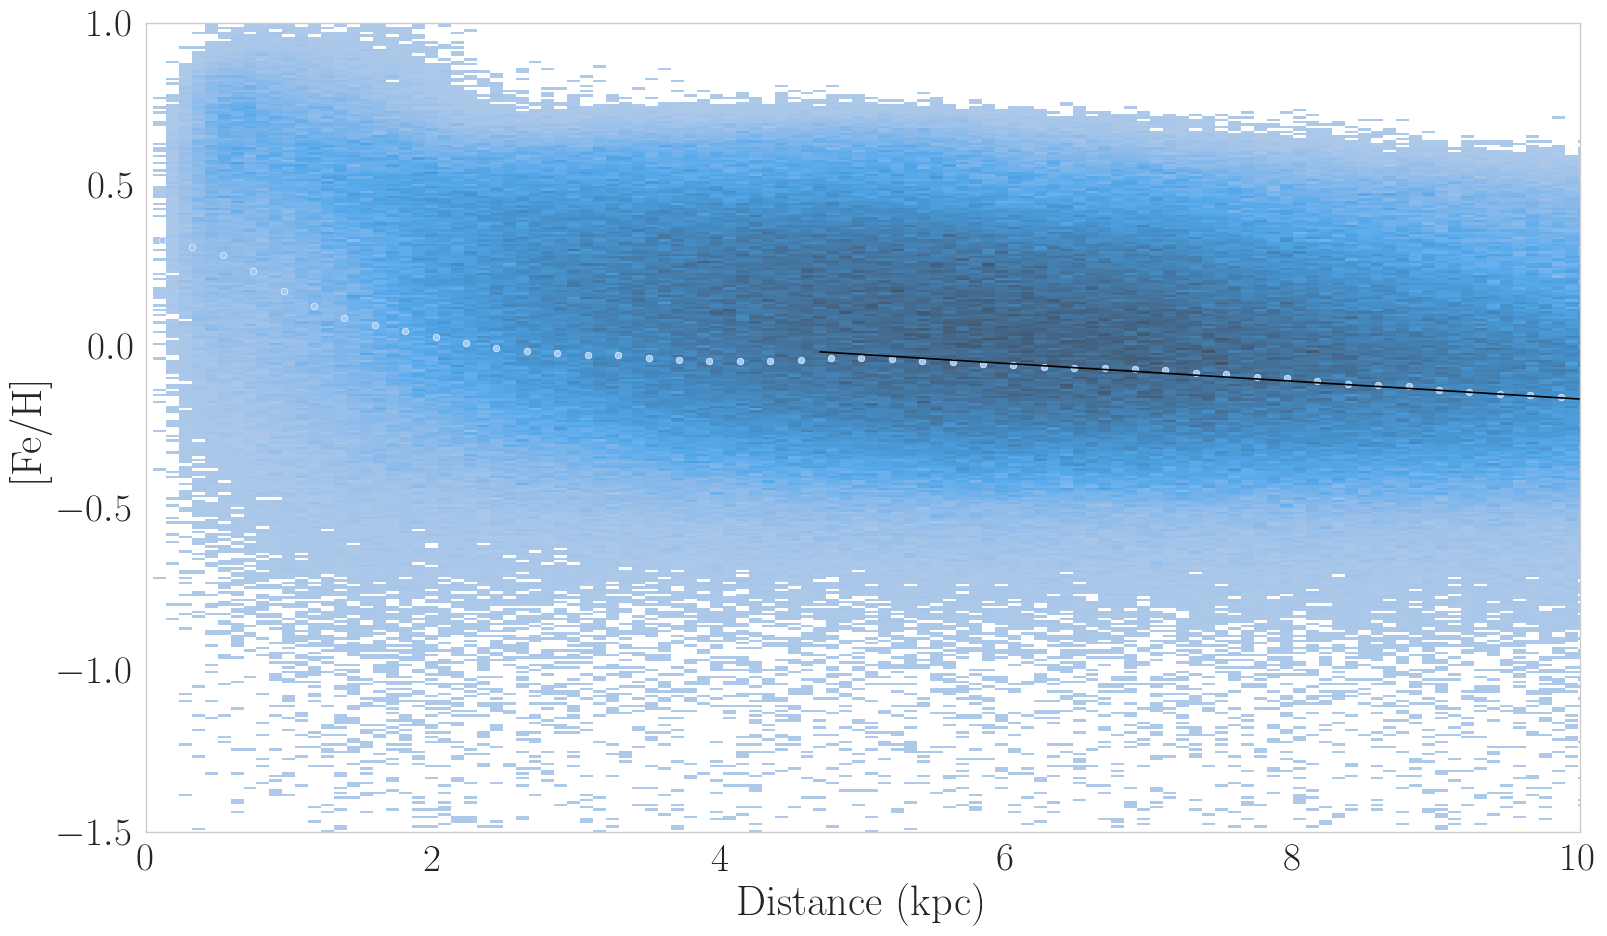

In [11]:
x = np.linspace(
    data_range["Distance (kpc)"].min(), data_range["Distance (kpc)"].max(), 100
)

sns.histplot(x=data["Distance (kpc)"], y=data["[Fe/H]"])
sns.scatterplot(x=profile["Distance (kpc)"], y=profile["[Fe/H]"])
plt.plot(x, regressor.coef_[0] * x + regressor.coef_[1], color="black")
plt.xlim(0, 10)
plt.ylim(-1.5, 1)